## Tweet Duygu Tanıma: TensorFlow ile Doğal Dil İşleme

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---

## Task 1: Giriş

## Task 2: Setup and Imports

1. Hugging Face'in nlp paketini yükleme
2. Import

In [17]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Tensorflowun kullandığımız versiyonu: ', tf.__version__)

Tensorflowun kullandığımız versiyonu:  2.9.2


## Task 3: Verileri İçe Aktarma

1. Tweet duygu veri kümesini içe aktarma
2. Train, valid ve test setleri oluşturma
3. Örneklerden tweet ve etiket çıkarma

In [23]:
from datasets import load_dataset

dataset = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [25]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [26]:
def twit_getir(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels


In [27]:
tweets, labels = twit_getir(train)

In [29]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tweetleri tokenize edelim

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK')
tokenizer.fit_on_texts(tweets)

In [33]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [34]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding ve Truncating Sequences

1. Tweetlerin uzunluğunu kontrol etme
2. Dolgulu diziler oluşturma

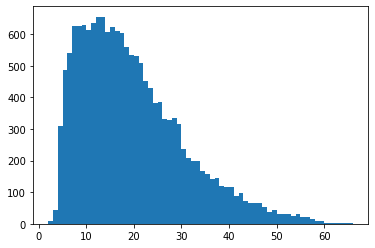

In [35]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [36]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
def sequences_getir(tokinizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [38]:
padded_train_seq = sequences_getir(tokenizer, tweets)

In [39]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Etiketlerin Hazırlanması

1. Dizine eklenecek sınıflar oluşturma ve sınıf sözlüklerine dizin oluşturma
2. Metin etiketlerini sayısal etiketlere dönüştürme

In [47]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


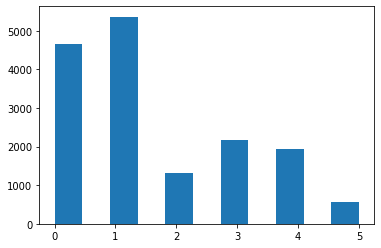

In [48]:
plt.hist(labels, bins=11)
plt.show()

In [49]:
# bizim verimizdeki sınıflar zaten sayısal olduğu için bu işlemi yapmamıza gerek
# yoktu ancak veri setinizdeki sınıflar string ifade olduğunda sayısal hala dönüştürmek
# gerekir.
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [50]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [51]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [52]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [57]:
train_labels = names_to_ids(labels)
print(train_labels[555])

2


## Task 7: Modelimizi oluşturalım.

1. Model oluşturma
2. Modeli derleme

In [59]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']

)


In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Modelimizi eğitelim

1. Doğrulama kümesi hazırlama
2. Modelin eğitimi

In [61]:
val_tweets, val_labels = twit_getir(val)
val_seq = sequences_getir(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [62]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [63]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 25s 40ms/step - loss: 1.3211 - accuracy: 0.4577 - val_loss: 0.8254 - val_accuracy: 0.6895
Epoch 2/20
500/500 [==============================] - 20s 39ms/step - loss: 0.5665 - accuracy: 0.7887 - val_loss: 0.5260 - val_accuracy: 0.8250
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.3035 - accuracy: 0.8987 - val_loss: 0.4234 - val_accuracy: 0.8545
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1905 - accuracy: 0.9391 - val_loss: 0.3962 - val_accuracy: 0.8745
Epoch 5/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1462 - accuracy: 0.9545 - val_loss: 0.3883 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 19s 39ms/step - loss: 0.1135 - accuracy: 0.9645 - val_loss: 0.4743 - val_accuracy: 0.8620
Epoch 7/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0922 - accuracy: 0.9714 - val_loss: 0.4198 - val_accuracy:

## Task 9: Modelin Değerlendirilmesi

1. Eğitim geçmişini görselleştirme
2. Test seti hazırlama
3. Test setindeki bireysel tahmin etme
4. Test setindeki tüm tahminleme

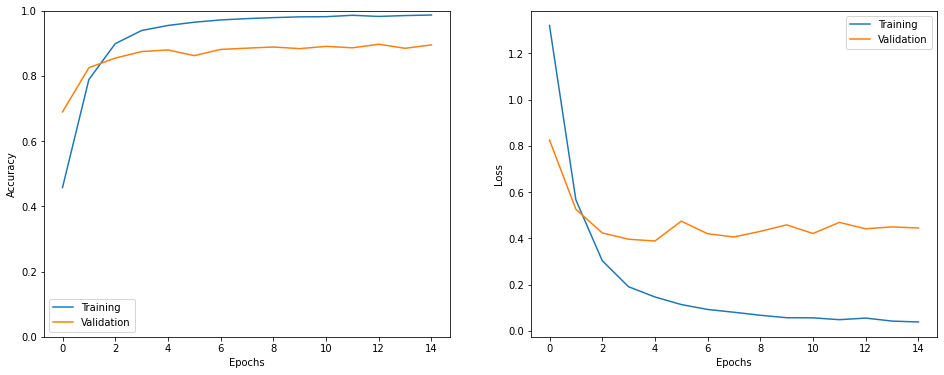

In [64]:
show_history(h)

In [66]:
test_tweets, test_labels = twit_getir(test)
test_seq = sequences_getir(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [68]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.4449 - accuracy: 0.8920


In [76]:
i = random.randint(0, len(test_labels) - 1)
print('cümle:', test_tweets[i])
print('cümlenin duygusu:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('tahminim:',pred_class)

cümle: i tried adding in any other type of cheese and we re talking small quantities i was right back to feeling shitty
cümlenin duygusu: 0
1/1 [==============================] - 0s 22ms/step
tahminim: 0


In [81]:
preds = model.predict(test_seq)

63/63 [==============================] - 1s 12ms/step
